# Text Analytics Group Assignment 1

Nicole Erich, Vishwa Bhuta, Caroline Nelson, Erik Honore, Lindsay Tober

---
## Part A (basic text mining)
---

In [21]:
# Import statements for Part A
import warnings
warnings.filterwarnings('ignore')
from pandas import Series, DataFrame
import pandas as pd
%pylab inline

import nltk
from nltk.corpus import wordnet
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as ss
import matplotlib

from nltk.stem import WordNetLemmatizer
import re
#nltk.download('wordnet')

# Import statements for Part B
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report

import os
import random
from operator import itemgetter
import csv



Populating the interactive namespace from numpy and matplotlib


### A1. What are the top 5 parts of speech in this corpus of job descriptions? How frequently do they appear?

In [6]:
# Read the file and take a subset
data=pd.read_csv('Train_rev1.csv')
job_descriptions=data['FullDescription'][:25000]
print data.columns.values

['Id' 'Title' 'FullDescription' 'LocationRaw' 'LocationNormalized'
 'ContractType' 'ContractTime' 'Company' 'Category' 'SalaryRaw'
 'SalaryNormalized' 'SourceName']


In [3]:
#nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter

# Tokenize series of job descriptions
list_of_words=[]
for i in range(len(job_descriptions)):
    new_text=job_descriptions[i].decode('utf-8')
    text=word_tokenize(new_text)
    list_of_words+=text
# Count parts of speech
dictionary=Counter([j for i,j in nltk.pos_tag(list_of_words)])
pos=sorted(dictionary.items(),key=lambda x:x[1],reverse=True)
pos[:5]


[('NN', 1048422),
 ('NNP', 797381),
 ('IN', 609559),
 ('JJ', 507262),
 ('DT', 461566)]

### A2. Does this corpus support Zipf’s law? Plot the most common 100 words in the corpus against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization.

In [7]:
# Create list of job descriptions using subset established in A1
job_descriptions_list = job_descriptions.values

In [8]:
# Use CountVectorizer to get word counts
vect = CountVectorizer(min_df=0, stop_words=None)
CountVect_X = vect.fit_transform(job_descriptions_list)

In [9]:
# Get list of terms and term frequencies from CountVectorizer
matrix_terms = np.array(vect.get_feature_names())
matrix_freq = np.asarray(CountVect_X.sum(axis=0)).ravel()
final_matrix = np.array([matrix_terms,matrix_freq])

In [28]:
# Prepare data in correct format for Zipf’s law analysis - [(word_1, freq_1),...,(word_n, freq_n)]
word_count_pairings = zip(matrix_terms, matrix_freq)
word_count_pairings[:10]

[(u'00', 250),
 (u'000', 176),
 (u'0000', 1),
 (u'0001636', 1),
 (u'00023', 1),
 (u'0005313', 1),
 (u'0006', 1),
 (u'0007', 2),
 (u'000my', 5),
 (u'000strong', 1)]

In [24]:
# Get WordNet data by word
# Generates rankings of each word in the set, by frequencies and number of 'synsets' or sets meanings
amb = []
amb_w = []
amb_c = []
amb_p = []
for (w, c) in word_count_pairings:
    if len(wordnet.synsets(w)) > 0:
        amb.append((w, c, len(wordnet.synsets(w))))
        amb_w.append((w))
        amb_c.append(c)
        amb_p.append(len(wordnet.synsets(w)))

amb_p_rank = ss.rankdata([p for (w, c, p) in amb])
amb_c_rank = ss.rankdata([c for (w, c, p) in amb])
amb_ranked = zip(amb_w, amb_c, amb_p, amb_p_rank, amb_c_rank)

In [25]:
# Quick test of Zipf's law - check correlation of rank to log of count
numpy.corrcoef(amb_c_rank, [math.log(c) for (w, c, p) in amb])

array([[ 1.        ,  0.96110207],
       [ 0.96110207,  1.        ]])

Based on the quick test above comparing correlation of rank to log of count, it appears as though this corpous supports Zipf's law.  This can be further validated by plotting the most common 100 words in the corpus of job descriptions against the theoretical prediction of the law.

In [26]:
# Select top 100 most frequent words and create dictionary of word:count
amb_ranked_sorted = sorted(amb_ranked, reverse=True, key=lambda (w, c, p, cr, pr): c)
top100_amb_ranked_sorted = amb_ranked_sorted[:100]
top100_dict = dict(zip([pair[0] for pair in top100_amb_ranked_sorted],[pair[1] for pair in top100_amb_ranked_sorted]))

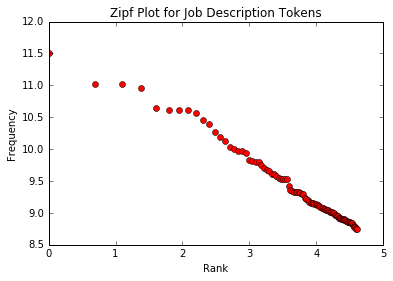

In [56]:
# Zipf plot 1 showing rank by frequency
# Uses example from https://www.garysieling.com/blog/exploring-zipfs-law-with-python-nltk-scipy-and-matplotlib

# Scale Rank
top100_amb_c_rank = [pair[4] for pair in top100_amb_ranked_sorted]
m = max(top100_amb_c_rank)
rank = [m-r+1 for r in top100_amb_c_rank]

# Zipf plot
plt.plot([math.log(c) for c in rank], [math.log(c) for (w, c, p, cr, pr) in top100_amb_ranked_sorted], 'ro')
title("Zipf Plot for Job Description Tokens")
xlabel("Rank")
ylabel("Frequency")
show()

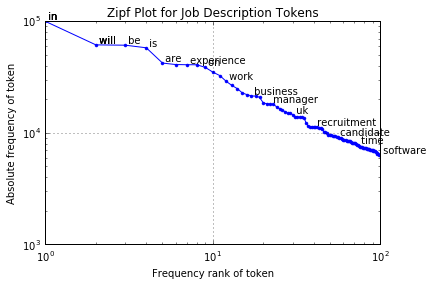

In [27]:
# Zipf plot 2 showing rank by frequency
# Uses example from https://finnaarupnielsen.wordpress.com/2013/10/22/zipf-plot-for-word-counts-in-brown-corpus/

# Token counts from the corpus
tokens = top100_dict.keys()
counts = array(top100_dict.values())

# Zipf plot
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
loglog(ranks, frequencies, marker=".")
title("Zipf Plot for Job Description Tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")

for n in list(logspace(-0.5, log10(len(counts)-1), 20).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

show()

The plots above evaluating applicability of Zipf's law for this corpus are not perfectly straight, but they are straight enough to support Zipf's law.  As size of the corpus, and thus word counts, increase, the graph should become more linear.

### A3. If we remove stopwords and lemmatize the corpus, what are the 10 most common words? What is their frequency?

In [22]:
#nltk.download('wordnet')
#nltk.download("stopwords")
wordnet_lemmatizer = WordNetLemmatizer()
string_of_words=' '.join(list_of_words)

#Split only words, excluding punctuation
split=re.split('\W+',string_of_words)

#Make every word in the list of strings lower case
words=[]
for i in range(len(split)):
    words.append(split[i].lower())

#Lemmatize new list
new_list=[]
for i in range(0,len(words)):
    new_list.append(wordnet_lemmatizer.lemmatize(words[i]))

#Remove stop words
from nltk.corpus import stopwords
filtered_words = [word for word in new_list if word not in stopwords.words('english')]
print filtered_words[:10]

from nltk import FreqDist
FreqDist(filtered_words).most_common(10)

[u'engineering', u'system', u'analyst', u'dorking', u'surrey', u'salary', u'k', u'client', u'located', u'dorking']


[(u'experience', 41068),
 (u'work', 29886),
 (u'role', 28534),
 (u'team', 27704),
 (u'client', 26580),
 (u'service', 23051),
 (u'working', 22795),
 (u'skill', 22662),
 (u'business', 22136),
 (u'manager', 21010)]

The above words are the 10 most common using the same subset as A1 (25,000).

---
## Part B (predict salary from job description)
---

### B1. Create a classification model with all words and the bag-of-words approach. How accurate is the model (show the confusion matrix)? 

In [29]:
# Sample for faster processing
random.seed(1)
docs_sample = data.sample(n=100000,replace=False)

In [30]:
# "Split" train and test the first time to calculate the quartile target
Y = docs_sample.ix[:,'SalaryNormalized']
X = docs_sample.ix[:,'FullDescription']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .33, random_state = 16) # seed at 16 to ensure reproducibility

In [31]:
salary_target = np.percentile(y_train, q = 75.0)
salary_target

42500.0

In [32]:
docs_sample['SalaryLevel'] = np.where(docs_sample['SalaryNormalized'] >= salary_target, 'high','low')

In [33]:
Y = docs_sample.ix[:,'SalaryLevel']
X = docs_sample.ix[:,'FullDescription']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = .33, random_state = 16) # seed at 16 to ensure reproducibility

In [35]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [36]:
# Create vectorizer for TF-IDF matrix
vectorizer = TfidfVectorizer(min_df=1, ngram_range=(1, 1))

In [37]:
# Transform X's for training and test sets
X_train1 = vectorizer.fit_transform(X_train)
X_test1 = vectorizer.transform(X_test)

In [38]:
# Fit Naive Bayes Multinomial
nb_classifier1 = MultinomialNB().fit(X_train1, y_train)

In [39]:
# Use NB to get predictions
y_nb_predicted1 = nb_classifier1.predict(X_test1)

In [40]:
# Print Confusion matrix
confusion_matrix1 = metrics.confusion_matrix(y_test, y_nb_predicted1, labels=unique(Y))
print confusion_matrix1

[[ 1366  7137]
 [  302 24195]]


In [41]:
# Accuracy for NB all words
print metrics.accuracy_score(y_test, y_nb_predicted1)

0.774575757576


### B2. Speculate before running the following analysis whether lemmatization would help improve the accuracy of classification. Now create a classification model after lemmatization. Did the classification accuracy increase relative to B1? Comment on your speculation versus the actual results you obtained.

We expect that using lemmatization will improve the accuracy of the predictions, because it reduces the vocabulary by removing variations of the same word.

In [42]:
# Building tokenizer and lemmatizer
lemmatizer=WordNetLemmatizer()

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    lemmas = []
    for item in tokens:
        lemmas.append(lemmatizer.lemmatize(item))
    return lemmas

In [43]:
# Tokenize training and test set X's
tfidf = TfidfVectorizer(tokenizer=tokenize)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [44]:
# Fit naive bayes multinomial model with tokenized training set
classifier = MultinomialNB().fit(X_train_tfidf, y_train)
classifier_pred=classifier.predict(X_test_tfidf)

In [45]:
# Print model report
print classification_report(y_test,classifier_pred)

             precision    recall  f1-score   support

       high       0.88      0.06      0.12      8503
        low       0.75      1.00      0.86     24497

avg / total       0.79      0.76      0.67     33000



In [46]:
# Print confusion matrix for NB with tokenization
print metrics.confusion_matrix(y_test, classifier_pred)

[[  542  7961]
 [   74 24423]]


In [47]:
# Get accuracy score for tokenization
print metrics.accuracy_score(y_test, classifier_pred)

0.756515151515


B2 Result: The accuracy of lemmatization is actually approximately 2% lower than the original approach using all words.  This is contrary to our expectation.  Lemmatization reduces the variations of words that exist in the corpus.  We believe that some of these variations would have been necessary to differentiate between low and high salary jobs.  If lemmatization removed some of these critical variations, predictions may have become less accurate.  

### B3. Now speculate whether stopwords removal from the original data would help increase the accuracy of the model. Take out the stopwords (but do not lemmatize), build a classification model and check the accuracy, and compare with that in B1 & B2.   Also show the top 10 words (excluding stopwords) that are most indicative of (i) high salary, and (ii) low salary. 

Removing stop words from the model will likely increase the accuracy (as we will be removing words that are so common, that they no longer provide much meaning to the descriptions).

However, because the model already calculates the TF-IDF scores, it will be taking care of stop words by down-weighting them.  We can expect the accuract to increase, but not by very much.

In [48]:
# Create vectorizer that removes stop words
vectorizer_stop = TfidfVectorizer(min_df=1, 
 ngram_range=(1, 1), 
 stop_words='english', 
 strip_accents='unicode', 
 norm='l2')

In [49]:
# Transform X's for training and test sets (same but with stop words)
X_train2 = vectorizer_stop.fit_transform(X_train)
X_test2 = vectorizer_stop.transform(X_test)

In [50]:
# Fit Naive Bayes Multinomial
nb_classifier2 = MultinomialNB().fit(X_train2, y_train)

In [51]:
# Use NB to get predictions
y_nb_predicted2 = nb_classifier2.predict(X_test2)

In [52]:
# Print Confusion matrix
confusion_matrix2 = metrics.confusion_matrix(y_test, y_nb_predicted2, labels=unique(Y))
print confusion_matrix2

[[ 1741  6762]
 [  370 24127]]


In [53]:
# Accuracy for NB no stop words
score2 = metrics.accuracy_score(y_test, y_nb_predicted2)
print score2

0.783878787879


As expected, removing the stop words did increase the accuracy of the "all words" model, but not by very  much. 

In [54]:
N = 10
vocabulary = np.array([t for t, i in sorted(vectorizer_stop.vocabulary_.iteritems(), key=itemgetter(1))])

In [55]:
for i in range(0,2):
    topN = np.argsort(nb_classifier2.feature_log_prob_[i])[-10:]
    print Y.value_counts().index[i] + " top 10:"
    print ", ".join(vocabulary[topN])
    

low top 10:
client, design, team, development, role, manager, management, project, experience, business
high top 10:
client, manager, working, skills, business, team, role, work, experience, sales


See above for the top 10 features associated with "low" and "high" salary ranges.  

There is some overlap between words that are very probable for both low and high salary descriptions.  Some examples of these words are "client," "manager," "team," and "experience."  These words may not be very helpful in classifying high versus low, because they are very likely to occur in either type of job description.  "Manager" could be referring to the position, or the person a lower-salaried employee would report to.  Both options make sense to include in a job description, which explains why the feature would be highly likely in either category.

### B4.  Use the job descriptions without lemmatization and stopword removal. Add parts-of-speech bigrams to the bag-of-words, and run a new classification model. Does the accuracy increase over the results in B1? 

In [57]:
from nltk.chunk.regexp import *
tag_pattern = "<NN.*><VB.*>|<JJ><NN>|<NNP><VB>|<NNP><VBP>|<NN><VB>|<VB><NNP>|<VB><NN>"
regexp_pattern = tag_pattern2re_pattern(tag_pattern)
regexp_pattern

u'(<(NN[^\\{\\}<>]*)>)(<(VB[^\\{\\}<>]*)>)|(<(JJ)>)(<(NN)>)|(<(NNP)>)(<(VB)>)|(<(NNP)>)(<(VBP)>)|(<(NN)>)(<(VB)>)|(<(VB)>)(<(NNP)>)|(<(VB)>)(<(NN)>)'

In [58]:
def tokenize1(text):
    tokens_unigrams = nltk.word_tokenize(text)
    bigram_tokenizer = nltk.tokenize.regexp.RegexpTokenizer(regexp_pattern)
    tokens_bigrams = bigram_tokenizer.tokenize(text)
    tokens= tokens_unigrams+tokens_bigrams
    return tokens

In [59]:
tfidf_bigram = TfidfVectorizer(tokenizer=tokenize1)
X_train_bigram = tfidf_bigram.fit_transform(X_train)
X_test_bigram = tfidf_bigram.transform(X_test)

In [60]:
classifier_bigram = MultinomialNB().fit(X_train_bigram, y_train)
bigram_pred=classifier_bigram.predict(X_test_bigram)

In [61]:
print metrics.confusion_matrix(y_test, bigram_pred)
print metrics.accuracy_score(y_test, bigram_pred)

[[  598  7905]
 [   84 24413]]
0.757909090909


The accuracy of this model is approximately 2% less than the model from B1.  After adding bigrams as additional features, it is possible that the model is now overfitting the data.  To avoid this problem, we would need to identify only the most significant part-of-speech bigrams.  